# **Irene Dovichi** 
## Midterm 2 - Assignment 3
Implement from scratch an RBM and apply it to DSET3. The RBM should be implemented fully by you (both CD-1 training and inference steps) but you are free to use library functions for the rest (e.g. image loading and management, etc.).

1. Train an RBM with a number of hidden neurons selected by you (single layer) on the MNIST data (use the training set split provided by the website).

2. Use the trained RBM to encode a selection of test images (e.g. using one per digit type) using the corresponding activation of the hidden neurons.

3. Train a simple classifier (e.g. any simple classifier in scikit) to recognize the MNIST digits using as inputs their encoding obtained at step 2. Use the standard training/test split. Show a performance metric of your choice in the presentation/handout.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from tqdm import tqdm

## Dataset Loading

In [2]:
def load_mnist_images(filename):
    with open(filename, 'rb') as f:
        data = np.frombuffer(f.read(), dtype=np.uint8, offset=16)
    return data.reshape(-1, 28*28) # reshape to 1D array, as needed for RBM 

def load_mnist_labels(filename):
    with open(filename, 'rb') as f:
        data = np.frombuffer(f.read(), dtype=np.uint8, offset=8)
    return data

dataset_folder = 'mnist_db/'

# Load train and test images
train_images = load_mnist_images(os.path.join(dataset_folder, 'train-images-idx3-ubyte'))
test_images = load_mnist_images(os.path.join(dataset_folder, 't10k-images-idx3-ubyte'))

# Load train and test labels
train_labels = load_mnist_labels(os.path.join(dataset_folder, 'train-labels-idx1-ubyte'))
test_labels = load_mnist_labels(os.path.join(dataset_folder, 't10k-labels-idx1-ubyte'))

Image shape: (784,)
Pixel value range: 0 - 255
Label: 5


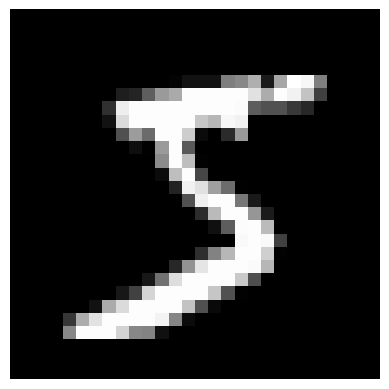

In [3]:
# Print the first image in the train set
first_image = train_images[0]
first_label = train_labels[0]

# Print the shape of the image
print("Image shape:", first_image.shape)

# Print the ranges of pixel values
print("Pixel value range:", first_image.min(), "-", first_image.max())

# Print the label of the image
print("Label:", first_label)

plt.imshow(first_image.reshape(28, 28), cmap='gray')
plt.axis('off')
plt.show()


### Data Preprocessing

In [4]:
# Normalize pixel values
train_images = train_images.astype('float32') / 255
test_images = test_images.astype('float32') / 255

# Binarize the images
threshold = 0.5
train_images_b = np.where(train_images > threshold, 1, 0)
test_images_b = np.where(test_images > threshold, 1, 0)

Image shape: (784,)
Pixel value range: 0 - 1


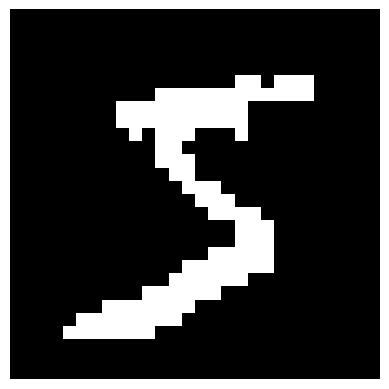

In [5]:
# See the change in the first image of the train set
first_image = train_images_b[0]

# Print the shape of the image
print("Image shape:", first_image.shape)

# Print the ranges of pixel values
print("Pixel value range:", first_image.min(), "-", first_image.max())

plt.imshow(first_image.reshape(28, 28), cmap='gray')
plt.axis('off')
plt.show()

## RBM Implementation 

## RBM Training Phase

In [ ]:
#TODO: provare senza binarizzazione (usare train_images e test_images al posto di train/test_images_b --> reshape a 1D vector)

## Encoding Phase

## Classification Phase

## Personal Considerations